# 0. Loading library

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


In [15]:
# Function to plot accuracy results
def plot_accuracy_results(results):
    learning_rates = list(set([r[0] for r in results]))
    weight_decays = list(set([r[1] for r in results]))

    accuracy_matrix = np.zeros((len(learning_rates), len(weight_decays)))

    for lr_idx, lr in enumerate(learning_rates):
        for wd_idx, wd in enumerate(weight_decays):
            for r in results:
                if r[0] == lr and r[1] == wd:
                    accuracy_matrix[lr_idx, wd_idx] = r[2]

    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=weight_decays, yticklabels=learning_rates)
    plt.xlabel('Weight Decay')
    plt.ylabel('Learning Rate')
    plt.title('Accuracy for different Hyperparameter combinations')
    plt.show()

# Plot accuracy results
#plot_accuracy_results(results)

# Train the best model on the full dataset and plot confusion matrix
best_lr, best_wd, _ = best_params
best_model = ClassifierModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_wd)

# Full dataset DataLoader with weighted sampling
full_data_loader = DataLoader(dataset, batch_size=32, sampler=sampler)

# Train the best model
best_model.train()
for epoch in range(20):
    for inputs, targets in full_data_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

# Validate and plot confusion matrix
def plot_confusion_matrix(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X).squeeze()
        preds = (outputs >= 0.5).float()
    
    cm = confusion_matrix(y.numpy(), preds.numpy())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#plot_accuracy_results(results)
#plot_confusion_matrix(best_model, X, y)


# 1. Generate toy data

In [16]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, n_clusters_per_class=1, weights=[0.9, 0.1], flip_y=0, random_state=1)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(X, y)

# 2. Define Classifier Model

In [17]:
class ClassifierModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassifierModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X.shape[1]
model = ClassifierModel(input_dim)


# 3. Correct for imbalance

In [13]:
# Compute class weights
class_counts = np.bincount(y.numpy())
class_weights = 1. / class_counts
samples_weights = class_weights[y]

# Create a weighted random sampler
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Create a DataLoader with the sampler
data_loader = DataLoader(dataset, batch_size=32, sampler=sampler)


# 4. Parameter scanning and cross validation

In [14]:
# Parameter search space
learning_rates = [1e-3, 1e-2, 1e-1]
weight_decays = [0, 1e-4, 1e-3]

# Cross-validation setup
kf = StratifiedKFold(n_splits=5)
results = []

# Perform random search
for lr, wd in product(learning_rates, weight_decays):
    fold_accuracies = []
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=WeightedRandomSampler(weights=samples_weights[train_index], num_samples=len(samples_weights[train_index]), replacement=True))
        
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=32)

        model = ClassifierModel(input_dim)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # Train the model
        model.train()
        for epoch in range(20):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets.float())
                loss.backward()
                optimizer.step()

        # Validate the model
        model.eval()
        all_preds = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.numpy())
        
        accuracy = accuracy_score(y_val, all_preds)
        fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    results.append((lr, wd, avg_accuracy))
    print(f"LR: {lr}, WD: {wd}, Accuracy: {avg_accuracy:.4f}")

# Find best parameters
best_params = max(results, key=lambda x: x[2])
print(f"Best Parameters - LR: {best_params[0]}, WD: {best_params[1]}, Accuracy: {best_params[2]:.4f}")


LR: 0.001, WD: 0, Accuracy: 0.9400
LR: 0.001, WD: 0.0001, Accuracy: 0.9430
LR: 0.001, WD: 0.001, Accuracy: 0.9500
LR: 0.01, WD: 0, Accuracy: 0.9130
LR: 0.01, WD: 0.0001, Accuracy: 0.9120
LR: 0.01, WD: 0.001, Accuracy: 0.9120
LR: 0.1, WD: 0, Accuracy: 0.9000
LR: 0.1, WD: 0.0001, Accuracy: 0.9090
LR: 0.1, WD: 0.001, Accuracy: 0.9160
Best Parameters - LR: 0.001, WD: 0.001, Accuracy: 0.9500


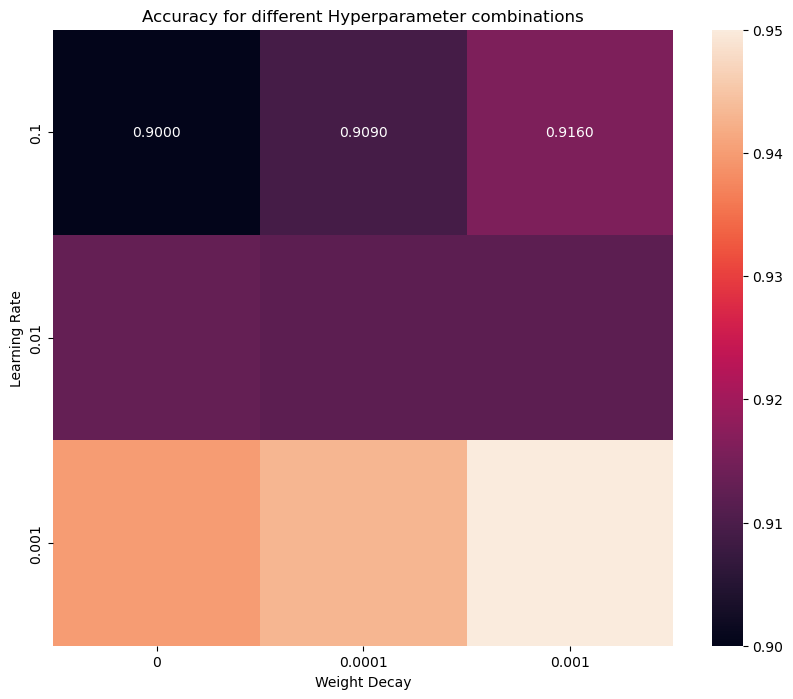

In [18]:
plot_accuracy_results(results)

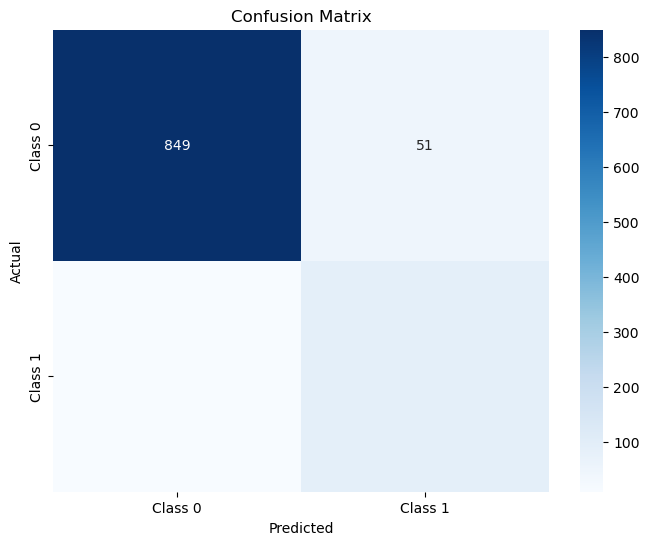

In [19]:
plot_confusion_matrix(best_model, X, y)